In [1]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
from subprocess import call
import imageio.v2 as imageio
import os
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    path = extSSDpath + getProjectFoldername() + '/evo_to_stationary_frozen/time_evos_dif_cond'
else:
    path = '/time_evos_dif_cond'

In [4]:
N, pi1, pi2, q1, q2, l = 35, 0.3, 0.3, 5, 10, 0.9
ar, ir, er, pushLabel = 20.0, 4.0, 1.5, 'nopush'
folder = f'time_evo_indv_states_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_ar_{ar}_ir_{ir}_er_{er}_{pushLabel}'
files = glob.glob(f'{path}/{folder}/*')

In [6]:
file0 = files[0]
csv_name = file0.split('/')[-1]
config_id = int(csv_name.split('_')[5])

# Individual State Evolution:
df_indv_states = pd.read_csv(file0, header=None)
# Positions:
df_config = pd.read_csv(f'{extSSDpath}/quenched_configs/{N}_bots/configs_wo_push/'+
                        f'bots_xy_positions_{config_id}_ar_{ar}_er_{er}.txt', sep='\s+', header=None, index_col=False)
df_config.rename(columns={0:'bot_id', 1:'x', 2:'y'}, inplace=True)
# Contacts:
try:
    df_contacts = pd.read_csv(f'{extSSDpath}/quenched_configs/{N}_bots/configs_wo_push/'+
                        f'contact_list_{config_id}_ar_{ar}_er_{er}_ir_{ir}.txt', sep='\s+',header=None)
    g = ig.Graph.DataFrame(df_contacts, directed=False)
    vertices_ids = [v['name'] for v in g.vs]
    lacking_vertices = [i for i in range(1,N+1) if i not in vertices_ids]
    # Add the lacking vertex without any contact
    for v in lacking_vertices:
        g.add_vertex(name=v)
    vertices_ids = [v['name'] for v in g.vs]
except pd.errors.EmptyDataError:
    print('No contacts!')

# Get the positions layout:
true_layout = []
for i in vertices_ids:
    x, y = float(df_config.loc[df_config['bot_id']==i]['x']), float(df_config.loc[df_config['bot_id']==i]['y'])
    true_layout.append([x, y])

true_layout = ig.Layout(true_layout)

KeyError: 'Attribute does not exist'

In [4]:
def plot_sys_state(g, true_layout, time_step, indv_states, ar, ir, er):
    colors = ['xkcd:red', 'xkcd:green', 'xkcd:blue']
    fig, ax = plt.subplots(figsize=(5,5))
    ig.plot(
        g, target=ax, layout=true_layout, vertex_size=5, vertex_color="steelblue",
        vertex_frame_width=2.0, vertex_frame_color="white"
    )
    circle = plt.Circle([0.0, 0.0], ar, fill=False, edgecolor='k')
    ax.add_patch(circle)
    ar_pad = 0.5
    ax.set_xlim(-(ar+ar_pad),ar+ar_pad)
    ax.set_ylim(-(ar+ar_pad),ar+ar_pad)
    for i in range(N):
        coords = true_layout[i]
        indv_state = indv_states.iloc[i]
        circle = plt.Circle(tuple(coords), er, color=colors[indv_state], alpha=0.5, clip_on=False)
        ax.add_patch(circle)
    plt.axis('off')
    #extra: radi interacció pel bot id 3, que sembla que no té veins
    # circle = plt.Circle(true_layout[-1], ir, fill=False, edgecolor='xkcd:grey', ls='--')
    # ax.add_patch(circle)
    fig.text(0.10, 0.85, f't = {time_step}')
    fig.tight_layout()
    fig.savefig(f'png_for_gif/state_{str(time_step).zfill(3)}.png')
    plt.close(fig)

In [18]:
# plot time evo visualization
step = 5
start_at = 500
end_at = 800

if os.path.exists('png_for_gif/'):
    call('rm -r png_for_gif', shell=True)
call('mkdir -p png_for_gif/', shell=True)

# first plot every tine_step:
for i in range(start_at,end_at+1,step):
    plot_sys_state(g, true_layout, i, df_indv_states.iloc[i], ar, ir, er)

if step == 1:
    gifName = f'evo_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_ar_{ar}_ir_{ir}_er_{er}_{pushLabel}_ini_{start_at}_fin_{end_at}.gif'
else:
    gifName = f'evo_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_ar_{ar}_ir_{ir}_er_{er}_{pushLabel}_ini_{start_at}_fin_{end_at}_step_{step}.gif'
figures = sorted(glob.glob('png_for_gif/*'))
with imageio.get_writer(f'{gifName}', mode='I', duration=0.5) as writer:
    for figure in figures:
        image = imageio.imread(figure)
        writer.append_data(image)


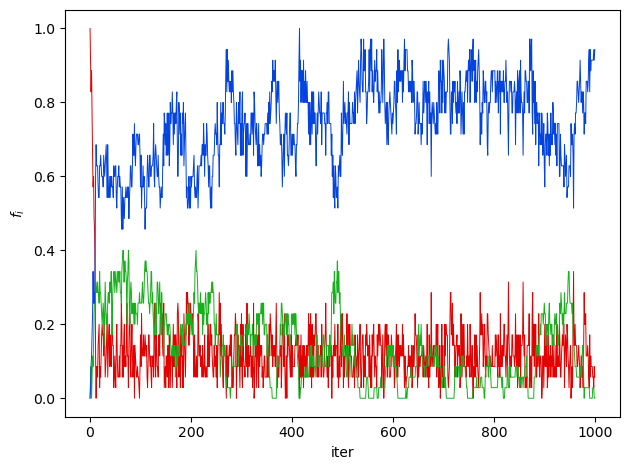

In [67]:
# global time evo:
folder_global_evo = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_ar_{ar}_ir_{ir}_er_{er}_{pushLabel}'
files_global_evo = glob.glob(f'{path}/{folder_global_evo}/*')
df_evo = pd.read_csv(files_global_evo[0])

fig, ax = plt.subplots()
ax.plot(df_evo['iter'], df_evo['f0'], color='xkcd:red', lw=0.7)
ax.plot(df_evo['iter'], df_evo['f1'], color='xkcd:green', lw=0.7)
ax.plot(df_evo['iter'], df_evo['f2'], color='xkcd:blue', lw=0.7)
ax.set(xlabel='iter', ylabel=r'$f_i$')
fig.tight_layout()